# Analyze a Corpus of Court of Appeals Decisions to Determine whether the Supreme Court will hear it

In [2]:
#!/usr/bin/python


#This script analyzes court of appeals decisions to predict whether, if a litigant petitions the Supreme Court
#of the United States (SCOTUS) to hear the case (i.e. grant certiorari), whether SCOTUS will grant a hearing or not. 
#Usage: python ~/Location_of_script/SCOTUS_analysis_final.py

#This script takes in a dataframe 
import sqlite3
from bs4 import BeautifulSoup
import re
import sys
import math
import os
import optparse
import json
import time
import matplotlib.pylab as plt
import requests
import pandas as pandas
import numpy
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

import sklearn
import pickle
import random
import math
import seaborn
import statistics
import nltk
#import library of functions. Change the path to wherever you keep the functions
exec(open("/Users/joshuabroyde/Scripts/Modules/myFunctions.py").read())



In [3]:
#Read in the dataframe that contains the Decision ID, the label (was it heard of not), and location of the decision
df=readdataframe_header("/Users/joshuabroyde/Projects/Supreme_Court_Data/All_Decisions/SCOTUS_certiorari.tsv")
#for now, exclue cases with a column labal=2, these are remanded cases
df=df[df.label != 2]
#df[df["label"].isnull()]
df=df.dropna()


In [4]:
#Here is what the input dataframe looks like; the first column is the ID of the case, 
#the second column is whether it was granted cert (1 for yes, 0 for no) and the file location
df.loc()[1:10,]

,ID,label,file_location
1,81423,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
2,81438,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
3,81448,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
4,91088,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
5,911328,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
6,9115,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
7,91156,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
8,91205,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
9,91273,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...
10,91279,1,/Users/joshuabroyde/Projects/Supreme_Court_Dat...


### Extract Basic Features from the Decision Texts

In [5]:
#create feature data frame, that has the same number of rows as the first data frame
df_features = pandas.DataFrame(index=df.index)
#start adding features row by row
df_features["Decision_length"] = np.nan
#get the length of the decision
for index,row in df.iterrows():
	file_location=row[2]
	#print(file_location)
	#get decision length
	f= open(file_location, 'r',encoding="ISO-8859-1").read()
	#word count
	decision_length=len(f.split())
	df_features.loc[index] = pandas.Series({"Decision_length" : decision_length})
	#print(str(index))

#does the opinion have the word "disagree", indicating possible disagreement with precident. 1 means it uses the phrase
df_features["disagree"] = np.nan
for index,row in df.iterrows():
	file_location=row[2]
	#print(file_location)
	f= open(file_location, 'r',encoding="ISO-8859-1").read()	#word 
	m=re.search("disagree",f)
	add=0
	if m:
		add=1
	df_features.loc[index,"disagree"] = add
	#print(str(index))
#does the opinion have the word "sister " in it, indicating potential disagreement with that court (refered to commonly as sister court. 1 means it uses the phrase
df_features["sister"] = np.nan
for index,row in df.iterrows():
	file_location=row[2]
	#print(file_location)
	f= open(file_location, 'r',encoding="ISO-8859-1").read()	#word 
	m=re.search("sister",f)
	add=0
	if m:
		add=1
	df_features.loc[index,"sister"] = add
	#print(str(index))
    
#does the opinion have the word "dissent " in it, indicating split in the court?
df_features["dissent_others"] = np.nan
for index,row in df.iterrows():
	file_location=row[2]
	#print(file_location)
	f= open(file_location, 'r',encoding="ISO-8859-1").read()	#word 
	m=re.search("dissent",f)
	add=0
	if m:
		add=1
	df_features.loc[index,"dissent_others"] = add
	#print(str(index))

#save the original features
df_features_original=df_features


In [6]:
#This is what the feature matrix looks like at this point in the analysis
df_features.loc()[1:10,]

,Decision_length,disagree,sister,dissent_others
1,4441.0,0.0,0.0,0.0
2,9348.0,0.0,0.0,0.0
3,8773.0,1.0,1.0,0.0
4,22493.0,1.0,1.0,1.0
5,3839.0,1.0,0.0,1.0
6,6221.0,0.0,0.0,0.0
7,8149.0,1.0,0.0,0.0
8,4057.0,1.0,0.0,0.0
9,7530.0,0.0,0.0,1.0
10,4738.0,1.0,0.0,0.0


### Now we will extract all unigrams from the texts and perform TF-IDF on the resulting unigrams to extract normalized word frequencies in the texts and use that feature matrix in a logistic regression classifier.

In [7]:
#get all unigrams from the text
all_text=""
for index,row in df.iterrows():
    file_location=row[2]
    #print(file_location)
    f= open(file_location, 'r',encoding="ISO-8859-1").read()	#word 
    text =f
    all_text=all_text+text
   #print(index)

#get unigram word tokens
all_text_list=list()
for index,row in df.iterrows():
    file_location=row[2]
    #print(file_location)
    f= open(file_location, 'r',encoding="ISO-8859-1").read()	#word 
    text =f
    all_text_list.append(text)
    #print(index)



In [8]:
#perform TF-IDF on the corpus of the text. This takes a few minues
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
                        use_idf=True, 
                        norm=None, 
                        smooth_idf=False, 
                        sublinear_tf=False, 
                        binary=False,
                        min_df=1, max_df=1.0, max_features=None,
                        strip_accents='unicode', 
                        ngram_range=(1,1), preprocessor=None,              stop_words=None, tokenizer=None, vocabulary=None
             )

tf_idf_result = vectorizer.fit_transform(all_text_list)
idf = vectorizer.idf_
#print (dict(zip(vectorizer.get_feature_names(), idf)))
#Get the scores from TF-IDF
tf_idf_scores=dict(zip(vectorizer.get_feature_names(), idf))



In [9]:
#convert the tfidf resultsto the feature dataframe
tf_idf_matrix=tf_idf_result.todense()
df_tfidf=pandas.DataFrame(tf_idf_matrix)

#append these features to the feature matrix
df_tfidf.columns=vectorizer.get_feature_names()
#frames=[df_features,df_tfidf]


#now append the TF-IDF features to the original features
df_features=df_features_original.join(df_tfidf,lsuffix='_left')

#Filter features for those that have numbers and those that have less than 10 letters, 
all_features=df_features.columns

#only keep features at least in a certain number of documents (i.e. number threshold)

nums_in_columns=df_features.astype(bool).sum(axis=0)
number_threshold=2000 #2000 documents
features_at_least_threshold=nums_in_columns[nums_in_columns >= number_threshold]
features_at_least_threshold_id=features_at_least_threshold.index
features_to_keep=["Decision_length","sister","dissent_others"]
for i in features_at_least_threshold_id:
    flag=1
    
    #remove less than 10 letters, to decrease size of feature matrix
    if len(i)<=10:
        flag=0
    #no digits
    m=re.search(r'\d',i)
    if m:
        flag=0
    
    if flag==1:
    	features_to_keep.append(i)
    else:
    	pass
    #print (i)
    
#only keep features that passed the feature filter threshold
features_to_keep=unique(sorted(features_to_keep))
df_features_full=df_features
df_features=df_features[features_to_keep]


In [10]:
#Do logistic regression on the dataset to come up with a predictive model
df_predictions=pandas.DataFrame(index=df.index)
df_predictions["average_score"]=np.nan

#df_predictions["average_score"]=df_predictions["average_score"]/number_iterations

logistic=sklearn.linear_model.LogisticRegressionCV(penalty='l2',cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10))
model=logistic.fit(df_features,df["label"])
predicted=model.predict_proba(df_features)
just_positive_probability=[row[1] for row in predicted]
df_predictions["average_score"]=just_positive_probability

#save the predictions and the model
df_predictions.to_csv("output_predictions.csv",sep="\t")
df.to_csv("original_datafram.csv",sep="\t")



0.80


/Users/joshuabroyde/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



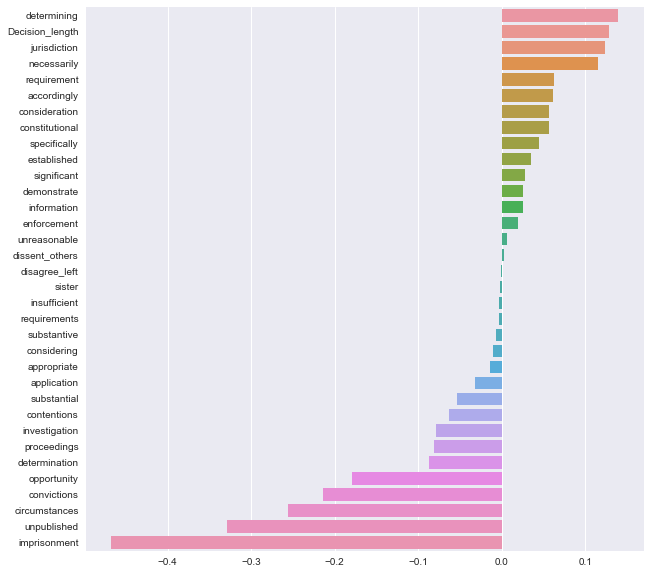

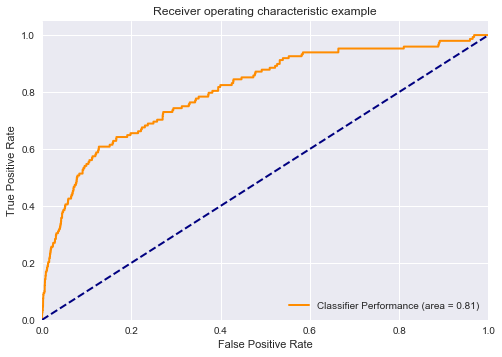

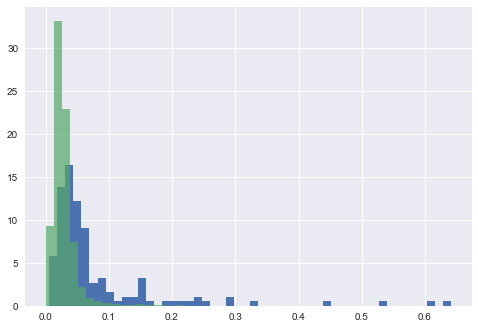

In [39]:
#Now plot roc curves to measure performance
fpr, tpr, blah=metrics.roc_curve(y_score=df_predictions["average_score"],y_true=df["label"],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print(str(roc_auc)[:4])
#print(roc_auc)
lw = 2
fig=plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Classifier Performance (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.show()
fig.savefig('ROCplot.pdf')
fig.show()
#Normalize the scores so that 2 is twice above random, 1, is random etc.
mean_score=statistics.mean(df_predictions["average_score"])
df_predictions["mean_normalized"]=np.nan
#plot histogram of predictions 
true_index=df[df.label == 1].index
df_true_only=df_predictions.iloc[true_index,]
#df_true_only=df_predictions.iloc[true_index,]
df_true_only = df_true_only.assign(mean_normalized=np.nan)
df_predictions = df_predictions.assign(mean_normalized=np.nan)
df_predictions.loc[:,"mean_normalized"]=df_predictions.loc[:,"average_score"]
df_true_only.loc[:,"mean_normalized"]=df_true_only.loc[:,"average_score"]
# df_true_only


fig=plt.figure()
plt.hist(np.clip(df_true_only["average_score"],0,10),label = 'Granted',bins=50,normed=True)
plt.hist(np.clip(df_predictions["average_score"],0,10),label = 'Random',bins=50,normed=True,alpha=0.7)
#plt.xlim([0,10])
#plt.legend()
plt.plot()
plt.show()

#plt.legend()
fig.savefig('HISTplot.pdf')

#Now get feature importance:

data_frame_of_feature_importance=pandas.DataFrame(np.std(df_features,0)*numpy.array(model.coef_[0]))
#print(np.std(df_features, 0)*model.coef_)
data_frame_of_feature_importance=data_frame_of_feature_importance.sort_values([0],ascending=False)

 
#A=data_frame_of_feature_importance[0].tolist()

#X = range(3)

A=data_frame_of_feature_importance[0].tolist()
#plt.bar(A,height=range(len(A)),color = 'skyblue')
fig=plt.figure(figsize=(10, 10))
seaborn.barplot(A,data_frame_of_feature_importance.index)
fig.savefig('BARplot.pdf')


#save the tfidf corpus, features and model
pickle.dump(tf_idf_result, open("tf_idf_result.txt", 'wb'))
pickle.dump(df_features, open("features_to_use.txt", 'wb'))
#save the model itself
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))




